# Linear regression

Let’s see how we can make the linear regression model while doing a few work with PyTorch.

In [2]:
# import PyTorch and its related packages
import torch as T
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

# set default device based on CUDA's availability
device = 'cuda' if T.cuda.is_available() else 'cpu'
device


'cpu'

## Linear regression

To get our feet wet, we'll start off by looking at the problem of regression.
This is the task of predicting a *real valued target* $y$ given a data point $x$.
In linear regression, the simplest and still perhaps the most useful approach,
we assume that prediction can be expressed as a *linear* combination of the input features 
(thus giving the name *linear* regression):

$$\hat{y} = w_1 \cdot x_1 + ... + w_d \cdot x_d + b$$

Given a collection of data points $X$, and corresponding target values $\boldsymbol{y}$, 
we'll try to find the *weight* vector $\boldsymbol{w}$ and bias term $b$ 
(also called an *offset* or *intercept*)
that approximately associate data points $\boldsymbol{x}_i$ with their corresponding labels $y_i$. 
Using slightly more advanced math notation, we can express the predictions $\boldsymbol{\hat{y}}$
corresponding to a collection of datapoints $X$ via the matrix-vector product:

$$\boldsymbol{\hat{y}} = X \boldsymbol{w} + b$$

Before we can get going, we will need two more things 

* Some way to measure the quality of the current model  
* Some way to manipulate the model to improve its quality

### Square loss

In order to say whether we've done a good job, 
we need some way to measure the quality of a model. 
Generally, we will define a *loss function*
that says *how far* are our predictions from the correct answers.
For the classical case of linear regression, 
we usually focus on the squared error.
Specifically, our loss will be the sum, over all examples, of the squared error $(y_i-\hat{y})^2)$ on each:

<center>$$\ell(y, \hat{y}) = \sum_{i=1}^n (\hat{y}_i-y_i)^2.$$</center>

For one-dimensional data, we can easily visualize the relationship between our single feature and the target variable. It's also easy to visualize a linear predictor and it's error on each example. 
Note that squared loss *heavily penalizes outliers*. For the visualized predictor below, the lone outlier would contribute most of the loss.

<center>![](../img/linear-regression.png)</center>

### Manipulating the model

For us to minimize the error,
we need some mechanism to alter the model.
We do this by choosing values of the *parameters*
$\boldsymbol{w}$ and $b$.
This is the only job of the learning algorithm.
Take training data ($X$, $y$) and the functional form of the model $\hat{y} = X\boldsymbol{w} + b$.
Learning then consists of choosing the best possible $\boldsymbol{w}$ and $b$ based on the available evidence.


### Historical note

You might reasonably point out that linear regression is a classical statistical model.
[According to Wikipedia](https://en.wikipedia.org/wiki/Regression_analysis#History), 
Legendre first developed the method of least squares regression in 1805,
which was shortly thereafter rediscovered by Gauss in 1809. 
Presumably, Legendre, who had Tweeted about the paper several times,
was peeved that Gauss failed to cite his arXiv preprint. 

<center>![Legendre](../img/legendre.jpeg)</center>

Matters of provenance aside, you might wonder - if Legendre and Gauss 
worked on linear regression, does that mean there were the original deep learning researchers?
And if linear regression doesn't wholly belong to deep learning, 
then why are we presenting a linear model 
as the first example in a tutorial series on neural networks? 
Well it turns out that we can express linear regression 
as the simplest possible (useful) neural network. 
A neural network is just a collection of nodes (aka neurons) connected by directed edges. 
In most networks, we arrange the nodes into layers with each feeding its output into the layer above. 
To calculate the value of any node, we first perform a weighted sum of the inputs (according to weights `w`) 
and then apply an *activation function*. 
For linear regression, we only have two layers, one corresponding to the input (depicted in orange) 
and a one-node layer (depicted in green) correspnding to the ouput.
For the output node the activation function is just the identity function.

<center>![](../img/onelayer.png)</center>

While you certainly don't have to view linear regression through the lens of deep learning, 
you can (and we will!).
To ground the concepts that we just discussed in code, 
let's actually code up a neural network for linear regression from scratch.

To get going, we will generate a simple synthetic dataset by sampling random data points `X[i]` and corresponding labels `y[i]` in the following manner. Out inputs will each be sampled from a random normal distribution with mean $0$ and variance $1$. Our features will be independent. Another way of saying this is that they will have diagonal covariance.  The labels will be generated accoding to the *true* labeling function `y[i] = 2 * X[i][0]- 3.4 * X[i][1] + 4.2 + noise` where the noise is drawn from a random gaussian with mean `0` and variance `.01`. We could express the labeling function in mathematical notation as:

$$y = X \cdot w + b + \eta, \quad \text{for } \eta \sim \mathcal{N}(0,\sigma^2)$$ 

In [3]:
num_inputs = 2
num_outputs = 1
num_examples = 10000
dtype = T.float

def real_fn(X):
    return 2 * X[:, 0] - 3.4 * X[:, 1] + 4.2

X = T.randn(num_examples, num_inputs, device=device, dtype=dtype)
noise = .1 * T.randn(num_examples, device=device, dtype=dtype)
y = (real_fn(X) + noise).view(-1, 1)

Notice that each row in ``X`` consists of a 2-dimensional data point and that each row in ``Y`` consists of a 1-dimensional target value. 

In [4]:
print(X[0])
print(y[0])

tensor([0.9028, 0.5603])
tensor([4.2092])


Note that because our synthetic features `X` live on `device` and because our noise also lives on `device`, the labels `y`, produced by combining `X` and `noise` in `real_fn` also live on `device`. 
We can confirm that for any randomly chosen point, a linear combination with the (known) optimal parameters produces a prediction that is indeed close to the target value

In [5]:
print(2 * X[0, 0] - 3.4 * X[0, 1] + 4.2)

tensor(4.1007)


We can visualize the correspondence between our second feature (`X[:, 1]`) and the target values `Y` by generating a scatter plot with the Python plotting package `matplotlib`. Make sure that `matplotlib` is installed. Otherwise, you may install it by running `pip2 install matplotlib` (for Python 2) or `pip3 install matplotlib` (for Python 3) on your command line. 

In order to plot with `matplotlib` we'll just need to convert `X` and `y` into NumPy arrays by using the `.asnumpy()` function. 

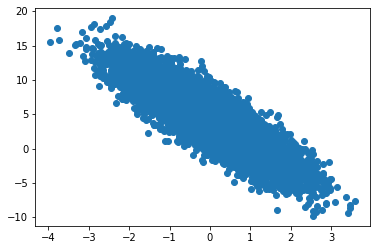

In [6]:
plt.scatter(X[:, 1].cpu().numpy(), y.cpu().numpy())
plt.show()

## Data iterators

Once we start working with neural networks, we're going to need to iterate through our data points quickly. We'll also want to be able to grab batches of `k` data points at a time, to shuffle our data. In PyTorch, data iterators give us a nice set of utilities for fetching and manipulating data. In particular, we'll work with the simple  `DataLoader` class, that provides an intuitive way to use an `Dataset` for training models.

We can load `X` and `y` into an `Dataset`, by writing a simple class. It's ok for `X` to be a multi-dimensional input array (say, of images) and `y` to be just a one-dimensional array of labels. The one requirement is that they have equal lengths along the first axis, i.e., `X.size()[0] == y.size()[0]`. 

Given an `Dataset`, we can create a `DataLoader` which will grab random batches of data from an `Dataset`.  We'll want to specify two arguments. First, we'll need to say the `batch_size`, i.e., how many examples we want to grab at a time. Second, we'll want to specify whether or not to shuffle the data between iterations through the dataset. 

In [7]:
class LinearDataset(Dataset):
    def __init__(self, X, y):
        assert X.size()[0] == y.size()[0]
        self.X = X
        self.y = y
    
    def __len__(self):
        return X.size()[0]
    
    def __getitem__(self, idx):
        return [X[idx], y[idx]]

In [8]:
batch_size = 4
train_data = DataLoader(LinearDataset(X, y), batch_size=batch_size, shuffle=True)

Once we've initialized our DataLoader (`train_data`), we can easily fetch batches by iterating over `train_data` just as if it were a Python list. You can use your favorite iterating techniques like foreach loops: `for data, label in train_data` or enumerations: `for i, (data, label) in enumerate(train_data)`. 
First, let's just grab one batch and break out of the loop.

In [9]:
for i, (data, label) in enumerate(train_data):
    print(data)
    print(label)
    break

tensor([[-0.7802,  1.5608],
        [ 1.4831,  0.0034],
        [ 0.1547,  0.6412],
        [ 0.4740, -1.3410]])
tensor([[-2.6427],
        [ 7.1457],
        [ 2.3641],
        [ 9.7435]])


If we run that same code again you'll notice that we get a different batch. That's because we instructed the `DataLoader` that `shuffle=True`. 

In [10]:
for i, (data, label) in enumerate(train_data):
    print(data)
    print(label)
    break

tensor([[-0.1165,  0.0046],
        [ 0.2697, -0.1978],
        [ 0.9201,  0.6179],
        [ 0.4382, -0.4728]])
tensor([[3.8257],
        [5.3372],
        [3.8963],
        [6.6257]])


Finally, if we actually pass over the entire dataset, and count the number of batches, we'll find that there are 2500 batches. We expect this because our dataset has 10,000 examples and we configured the `DataLoader` with a batch size of 4.

In [11]:
counter = 0
for i, (data, label) in enumerate(train_data):
    pass
print(i + 1)

2500


## Define the model

For a linear model, the appropriate layer is called `Linear`. It's called a linear layer because every node in the input is connected to every node in the subsequent layer. That description seems excessive because we only have one (non-input) layer here, and that layer only contains one node! But in subsequent chapters we'll typically work with networks that have multiple outputs, so we might as well start thinking in terms of layers of nodes. Because a linear model consists of just a single Dense layer, we can instantiate it with one line.

In [12]:
class LinearRegression(nn.Module):
    def __init__(self, **kwargs):
        super(LinearRegression, self).__init__(**kwargs)
        self.dense_1 = T.nn.Linear(2, 1)
        
    def forward(self, x):
        x = self.dense_1(x)
        return x
    
net = LinearRegression()
net.to(device)

LinearRegression(
  (dense_1): Linear(in_features=2, out_features=1, bias=True)
)

Ok, that was easy.

## Loss function

Train a model means making it better and better over the course of a period of training. But in order for this goal to make any sense at all, we first need to define what *better* means in the first place. In this case, we'll use the MSE between our prediction and the true value. Instead of writing our own loss function we’re just going to access squared error by instantiating `nn.MESLoss`.

In [13]:
loss_fn = nn.MSELoss()

## Optimizer

It turns out that linear regression actually has a closed-form solution. However, most interesting models that we'll care about cannot be solved analytically. So we'll solve this problem by stochastic gradient descent. At each step, we'll estimate the gradient of the loss with respect to our weights, using one batch randomly drawn from our dataset. Then, we'll update our parameters a small amount in the direction that reduces the loss. The size of the step is determined by the *learning rate* `lr`. 

In [14]:
optimizer = optim.SGD(net.parameters(), lr=1e-5, momentum=0.9)

## Execute training loop

Now that we have all the pieces, we just need to wire them together by writing a training loop. 
First we'll define `epochs`, the number of passes to make over the dataset. Then for each pass, we'll iterate through `train_data`, grabbing batches of examples and their corresponding labels. 

For each batch, we'll go through the following ritual:
     
* Generate predictions (`yhat`) and the loss (`loss`) by executing a forward pass through the network.
* Calculate gradients by making a backwards pass through the network (`loss.backward()`). 
* Update the model parameters by invoking our SGD optimizer, `use optimizer.step()`.     

In [15]:
epochs = 10
num_batches = num_examples / batch_size
losses = []

for e in range(epochs):
    cumulative_loss = 0
    # inner loop
    for i, (data, label) in enumerate(train_data):
        data = data.to(device)
        label = label.to(device)
        
        yhat = net(data)
        loss = loss_fn(yhat, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        cumulative_loss += loss.item()
    print("Epoch %s, loss: %s" % (e, cumulative_loss / num_examples))
    losses.append(cumulative_loss / num_batches)

Epoch 0, loss: 5.660791556739807
Epoch 1, loss: 2.0820876417472958
Epoch 2, loss: 0.7668356999084354
Epoch 3, loss: 0.28342551814704203
Epoch 4, loss: 0.1057416902472265
Epoch 5, loss: 0.04042888775628526
Epoch 6, loss: 0.016424476063647307
Epoch 7, loss: 0.007607210330905218
Epoch 8, loss: 0.0043663726225262505
Epoch 9, loss: 0.003174828359502135


## Visualizing the learning curve
Now let's check how quickly SGD learns the linear regression model by plotting the learning curve.

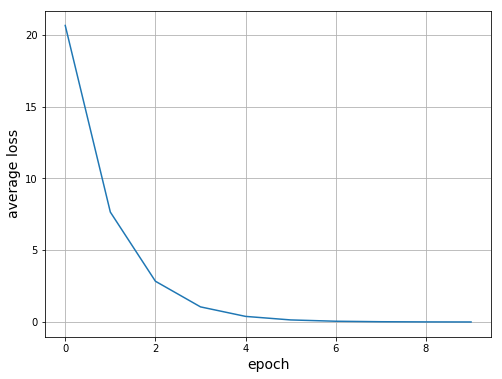

In [15]:
plt.figure(num=None, figsize=(8, 6))
plt.plot(losses)

# Adding some bells and whistles to the plot
plt.grid(True, which="both")
plt.xlabel('epoch', fontsize=14)
plt.ylabel('average loss', fontsize=14)
plt.show()

## Getting the learned model parameters

As an additional sanity check, since we generated the data from a Gaussian linear regression model, we want to make sure that the learner managed to recover the model parameters, which were set to weight $2,-3.4$ with an offset of $4.2$.

In [16]:
params = net.parameters()
print('The type of "params" is a ', type(params))

for name, param in net.named_parameters():
    if param.requires_grad:
        print(name, param.data)

The type of "params" is a  <class 'generator'>
dense_1.weight tensor([[ 1.9786, -3.3776]], device='cuda:0')
dense_1.bias tensor([ 4.1732], device='cuda:0')


## Visualizing our training progess

In the succeeding chapters, we'll introduce more realistic data, fancier models, more complicated loss functions, and more. But the core ideas are the same and the training loop will look remarkably familiar. Because these tutorials are self-contained, you'll get to know this ritual quite well. In addition to updating out model, we'll often want to do some bookkeeping. Among other things, we might want to keep track of training progress and visualize it graphically. We demonstrate one slighly more sophisticated training loop below.

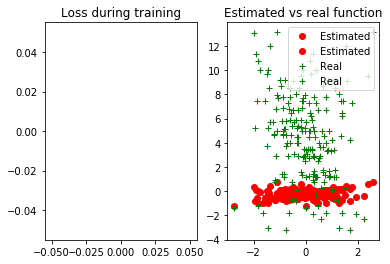

Epoch 0, batch 2499. Mean loss: 21.23622235829234
Epoch 1, batch 2499. Mean loss: 7.850917671012878
Epoch 2, batch 2499. Mean loss: 2.9073473278090356
Epoch 3, batch 2499. Mean loss: 1.0811181275499984
Epoch 4, batch 2499. Mean loss: 0.4061117010721937
Epoch 5, batch 2499. Mean loss: 0.15650875556683166
Epoch 6, batch 2499. Mean loss: 0.06415486732344143
Epoch 7, batch 2499. Mean loss: 0.029984261348628208
Epoch 8, batch 2499. Mean loss: 0.01734170236036007
Epoch 9, batch 2499. Mean loss: 0.01265756045926828


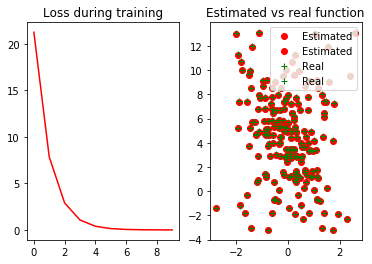

In [17]:
############################################
#   Re-initialize the model because it
#   is already trained in a previous cell
############################################
net = LinearRegression()
net.to(device)

learning_rate = 1e-5
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
############################################
#    Script to plot the losses over time
############################################
def plot(losses, X, sample_size=100):
    xs = list(range(len(losses)))
    f, (fg1, fg2) = plt.subplots(1, 2)
    fg1.set_title('Loss during training')
    fg1.plot(xs, losses, '-r')
    fg2.set_title('Estimated vs real function')
    fg2.plot(X[:sample_size].cpu().detach().numpy(),
             net(X[:sample_size, :]).cpu().detach().numpy(), 'or', label='Estimated')
    fg2.plot(X[:sample_size].cpu().detach().numpy(),
             real_fn(X[:sample_size, :]).cpu().detach().numpy(), '+g', label='Real')
    fg2.legend()

    plt.show()

losses = []
plot(losses, X)

for e in range(epochs):
    cumulative_loss = 0
    for i, (data, label) in enumerate(train_data):
        data = data.to(device)
        label = label.to(device)
        
        yhat = net(data)
        loss = loss_fn(yhat, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        cumulative_loss += loss.item()

    print("Epoch %s, batch %s. Mean loss: %s" % (e, i, cumulative_loss / num_batches))
    losses.append(cumulative_loss/num_batches)
            
plot(losses, X)

## Conclusion 

As you can see, even for a simple example like linear regression, `Pytorch` can help you to write quick and clean code. Next, we'll repeat this exercise for multi-layer perceptrons, extending these lessons to deep neural networks and (comparatively) real datasets. 